# Подбор гиперпараметров для RandomForest, CatBoost, XGBosst

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as mp
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

Подготовка данных

In [49]:
train_df = pd.read_csv('../data/train_preprocessed.csv')
test_df = pd.read_csv('../data/test_preprocessed.csv')

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']
X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

scaler = StandardScaler()

pipeline = mp(
    scaler,
    SMOTE(random_state=42)
)

X_train_processed, y_train_processed = pipeline.fit_resample(X_train, y_train)

X_test_processed = scaler.transform(X_test)

### Использование RandomiseSearchCV для подбора гиперпараметров моделей

In [50]:
import warnings
warnings.filterwarnings('ignore')

scoring = ['accuracy', 'f1', 'recall', 'roc_auc']
all_res = {}

def print_res(results):
    print('params:')
    for item, val in results['best_params'].items():
        print(f'    {item}: {val}')
    print('metrics:')
    for item, val in results['metrics'].items():
        print(f'    {item}: {val}')

#### Random Forest

In [51]:
params = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_depth': [3, 5, 7, 10, 12, 15, 17, 20, None],
    'min_samples_split': [2, 5, 8, 10, 12, 15, 18, 20],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 8, 10, 12, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

model = RandomForestClassifier(random_state=42)

results = {}

rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring=scoring,
    random_state=42,
    n_iter=20,
    n_jobs=-1,
    cv=3,
    refit='accuracy',
    return_train_score=True
)

rs.fit(X_train_processed, y_train_processed)

results['best_estimator'] = rs.best_estimator_
results['best_params'] = rs.best_params_
results['metrics'] = {
    metric: rs.cv_results_[f'mean_test_{metric}'][rs.best_index_]
    for metric in scoring
}

all_res['RandomForest'] = results

In [52]:
print_res(results)

params:
    n_estimators: 250
    min_samples_split: 12
    min_samples_leaf: 3
    max_features: sqrt
    max_depth: 20
    criterion: gini
metrics:
    accuracy: 0.8283443469155841
    f1: 0.8295035705020792
    recall: 0.8499793310982895
    roc_auc: 0.9103775433068323


Text(0.5, 1.0, 'min_samples_split vs min_samples_leaf')

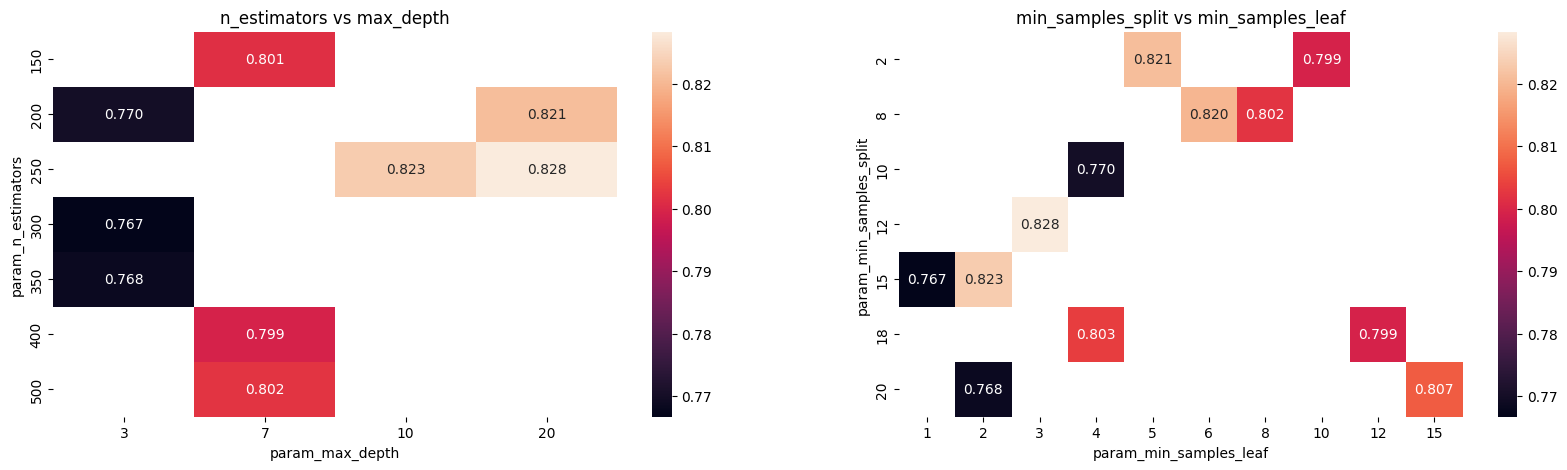

In [53]:
results_df = pd.DataFrame(rs.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

pivot1 = results_df.pivot_table(values='mean_test_accuracy', 
                               index='param_n_estimators', 
                               columns='param_max_depth')
sns.heatmap(pivot1, annot=True, fmt='.3f', ax=axes[0])
axes[0].set_title('n_estimators vs max_depth')

pivot2 = results_df.pivot_table(values='mean_test_accuracy',
                               index='param_min_samples_split',
                               columns='param_min_samples_leaf')
sns.heatmap(pivot2, annot=True, fmt='.3f', ax=axes[1])
axes[1].set_title('min_samples_split vs min_samples_leaf')

#### CatBoost

In [54]:
params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'l2_leaf_reg': [1, 3, 5, 7, 9, 10]
}

model = CatBoostClassifier(random_state=42, verbose=False, early_stopping_rounds=50)

results = {}

rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring=scoring,
    random_state=42,
    n_iter=10,
    n_jobs=-1,
    cv=3,
    refit='accuracy',
    return_train_score=True
)

rs.fit(X_train_processed, y_train_processed)

results['best_estimator'] = rs.best_estimator_
results['best_params'] = rs.best_params_
results['metrics'] = {
    metric: rs.cv_results_[f'mean_test_{metric}'][rs.best_index_]
    for metric in scoring
}

all_res['CatBoost'] = results

In [55]:
print_res(results)

params:
    learning_rate: 0.2
    l2_leaf_reg: 7
    iterations: 100
    depth: 12
metrics:
    accuracy: 0.8260581531150578
    f1: 0.8043210273704241
    recall: 0.8089272139371455
    roc_auc: 0.9336364020204448


Text(0.5, 1.0, 'learning_rate vs l2_leaf_reg')

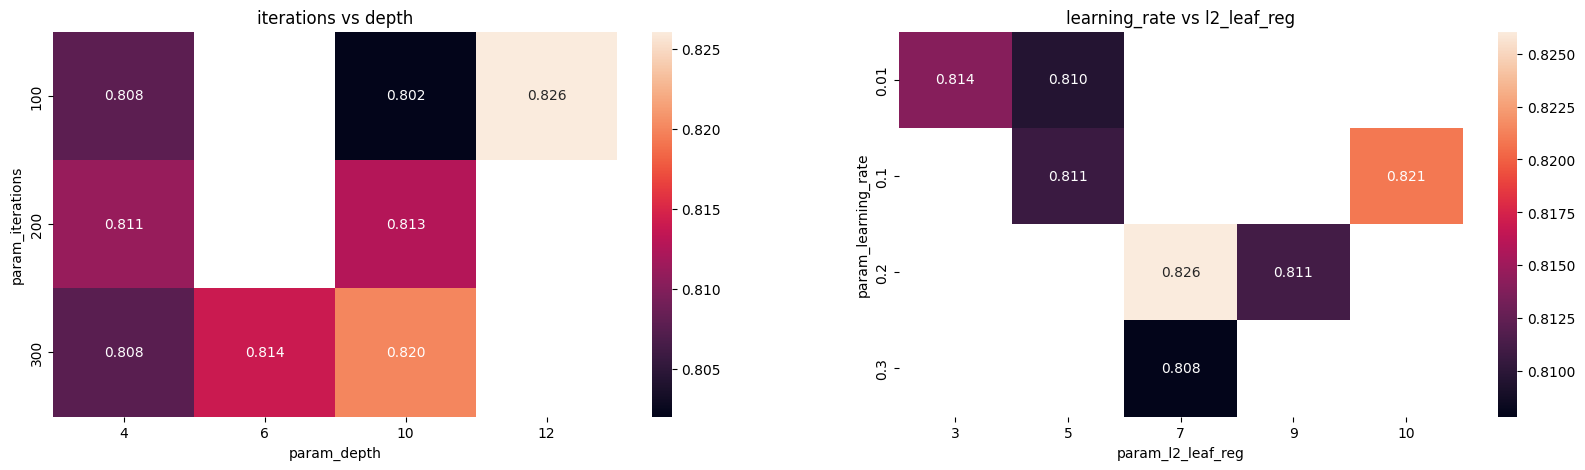

In [56]:
results_df = pd.DataFrame(rs.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

pivot1 = results_df.pivot_table(values='mean_test_accuracy', 
                               index='param_iterations', 
                               columns='param_depth')
sns.heatmap(pivot1, annot=True, fmt='.3f', ax=axes[0])
axes[0].set_title('iterations vs depth')

pivot2 = results_df.pivot_table(values='mean_test_accuracy',
                               index='param_learning_rate',
                               columns='param_l2_leaf_reg')
sns.heatmap(pivot2, annot=True, fmt='.3f', ax=axes[1])
axes[1].set_title('learning_rate vs l2_leaf_reg')

#### XGBoost

In [57]:
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

model = XGBClassifier(random_state=42)

results = {}

rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    scoring=scoring,
    random_state=42,
    n_iter=10,
    n_jobs=-1,
    cv=3,
    refit='accuracy',
    return_train_score=True
)

rs.fit(X_train_processed, y_train_processed)

results['best_estimator'] = rs.best_estimator_
results['best_params'] = rs.best_params_
results['metrics'] = {
    metric: rs.cv_results_[f'mean_test_{metric}'][rs.best_index_]
    for metric in scoring
}

all_res['XGBoost'] = results

In [58]:
print_res(results)

params:
    n_estimators: 500
    max_depth: 8
    learning_rate: 0.01
metrics:
    accuracy: 0.8287130130114355
    f1: 0.8184489093532746
    recall: 0.8296977085544731
    roc_auc: 0.9262243473468081


Text(0.5, 1.0, 'n_estimators vs max_depth')

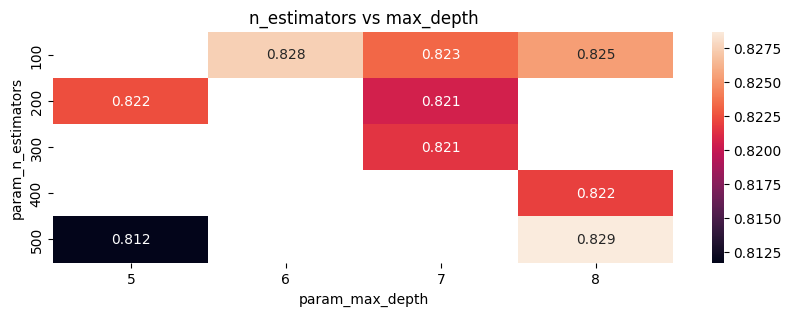

In [59]:
results_df = pd.DataFrame(rs.cv_results_)

plt.figure(figsize=(10, 3))
pivot1 = results_df.pivot_table(values='mean_test_accuracy', 
                               index='param_n_estimators', 
                               columns='param_max_depth')
sns.heatmap(pivot1, annot=True, fmt='.3f')
plt.title('n_estimators vs max_depth')

#### Сравнение качества

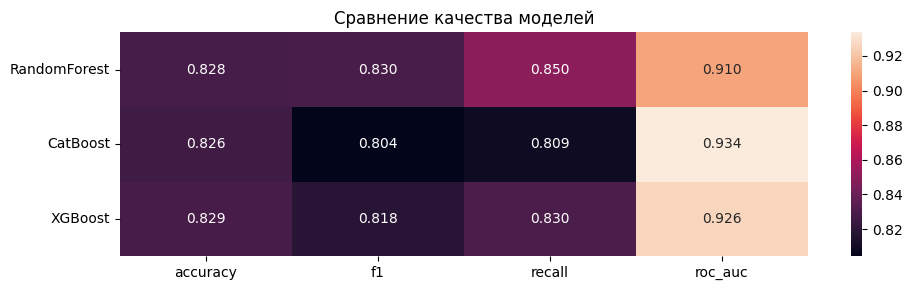

In [60]:
comp_df = pd.DataFrame.from_dict({
    model: info['metrics']
    for model, info in all_res.items()
}).T

plt.figure(figsize=(10, 3))
sns.heatmap(comp_df, annot=True, fmt='.3f')
plt.title('Сравнение качества моделей')
plt.tight_layout()
plt.show()

#### Сохранение лучшей модели

In [ ]:
import joblib

joblib.dump(all_res['RandomForest']['best_estimator'], '../model/trained_model.pkl')

['../src/trained_model.pkl']